In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime

In [2]:
# import seaborn and matplotlib for charting and data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [3]:
#import plotly and cufflinks for interactive visualisations
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

In [4]:
# To import csv file containing fundamental data downloaded from S&P Capital IQ, as well as other features and the labels for machine learning.
stockdata = pd.read_csv('cleaned stockdata.csv', index_col=0)

In [5]:
stockdata=pd.get_dummies(data=stockdata, columns=['Sector', 'Country.1','IQ_AUDITOR_OPINION'], drop_first=True, dummy_na=True).drop(['Country.1_nan','IQ_AUDITOR_OPINION_nan'],axis=1)

In [6]:
#To create a categorical variable based on effective annual return.
stockdata['Positive or negative returns'] = [1 if x >= 0 else 0 for x in stockdata['Effective annual return']]

In [7]:
stockdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2839 entries, 0 to 2949
Data columns (total 100 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Symbol                                                   2839 non-null   object 
 1   longName                                                 2839 non-null   object 
 2   Name                                                     2839 non-null   object 
 3   IPO Year                                                 1088 non-null   float64
 4   Effective annual return                                  2839 non-null   float64
 5   CIQ ID                                                   2839 non-null   object 
 6   Ticker                                                   2730 non-null   object 
 7   Short Business Description                               2831 non-null   object 
 8   IQ_TOTAL_REV               

<AxesSubplot:xlabel='Positive or negative returns', ylabel='count'>

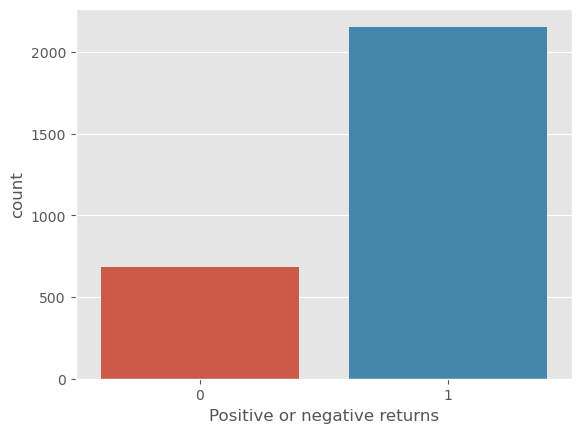

In [8]:
sns.countplot(x='Positive or negative returns',data=stockdata)

# Logistic regression model

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(stockdata.drop(['Symbol','longName','Name','IPO Year','Effective annual return','CIQ ID', 'Ticker', 'Short Business Description','Positive or negative returns'],axis=1), 
                                                    stockdata['Positive or negative returns'], test_size=0.30, 
                                                    random_state=101)

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
scaled_features=scaler.transform(X_train)

In [11]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(scaled_features,y_train)

LogisticRegression(max_iter=1000)

In [12]:
predictions = logmodel.predict(scaler.transform(X_test))

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.72      0.39      0.50       205
           1       0.83      0.95      0.89       647

    accuracy                           0.82       852
   macro avg       0.77      0.67      0.69       852
weighted avg       0.80      0.82      0.79       852



In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

array([[ 79, 126],
       [ 31, 616]], dtype=int64)

We note that the recall for negative returns is slightly low, meaning that the model falsely predicts more stocks to have positive returns when they in fact have negative returns. 

In [17]:
#Remove the dummy variables for Country.1 except for Country.1_United States
X_train, X_test, y_train, y_test = train_test_split(pd.concat([stockdata.iloc[:,8:48],stockdata['Country.1_United States'],stockdata.iloc[:,95:99]],axis=1), 
                                                    stockdata['Positive or negative returns'], test_size=0.30, 
                                                    random_state=101)

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
scaled_features=scaler.transform(X_train)

In [19]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(scaled_features,y_train)

LogisticRegression(max_iter=1000)

In [20]:
predictions = logmodel.predict(scaler.transform(X_test))

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.66      0.32      0.43       205
           1       0.82      0.95      0.88       647

    accuracy                           0.80       852
   macro avg       0.74      0.63      0.65       852
weighted avg       0.78      0.80      0.77       852



In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

array([[ 66, 139],
       [ 34, 613]], dtype=int64)

We note that the model performed slightly worse compared to when all Country.1 dummy variables were used.

**Recursive Feature Elimination**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(pd.concat([stockdata.iloc[:,8:48],stockdata['Country.1_United States'],stockdata.iloc[:,95:99]],axis=1), 
                                                    stockdata['Positive or negative returns'], test_size=0.30, 
                                                    random_state=101)

In [24]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_features=scaler.transform(X_train)

In [25]:
# Half of the features will be selected by default, by eliminating the least important feature by coef_ after recursively training.
from sklearn.feature_selection import RFE

rfe_selector = RFE(estimator=LogisticRegression(), step = 1)
rfe_selector.fit(scaled_features, y_train)
pd.DataFrame(scaled_features,columns=pd.concat([stockdata.iloc[:,8:48],stockdata['Country.1_United States'],stockdata.iloc[:,95:99]],axis=1).columns).columns[rfe_selector.get_support()]

Index(['IQ_TOTAL_REV', 'IQ_NI_MARGIN', 'IQ_ASSET_TURNS',
       'IQ_DAYS_INVENTORY_OUT', 'IQ_TOTAL_ASSETS_1YR_ANN_GROWTH',
       'IQ_PAYOUT_RATIO', 'IQ_GW', 'IQ_TBV', 'IQ_CASH_INVEST', 'IQ_NET_CHANGE',
       'Sector_Consumer Discretionary', 'Sector_Consumer Staples',
       'Sector_Energy', 'Sector_Finance', 'Sector_Industrials',
       'Sector_Real Estate', 'Sector_Technology', 'Sector_Utilities',
       'Country.1_United States', 'IQ_AUDITOR_OPINION_Qualified',
       'IQ_AUDITOR_OPINION_Unqualified',
       'IQ_AUDITOR_OPINION_Unqualified with Additional Language'],
      dtype='object')

In [26]:
X_train, X_test, y_train, y_test = train_test_split(stockdata[['IQ_TOTAL_REV', 'IQ_NI_MARGIN', 'IQ_ASSET_TURNS',
       'IQ_DAYS_INVENTORY_OUT', 'IQ_TOTAL_ASSETS_1YR_ANN_GROWTH',
       'IQ_PAYOUT_RATIO', 'IQ_GW', 'IQ_TBV', 'IQ_CASH_INVEST', 'IQ_NET_CHANGE',
       'Sector_Consumer Discretionary', 'Sector_Consumer Staples',
       'Sector_Energy', 'Sector_Finance', 'Sector_Industrials',
       'Sector_Real Estate', 'Sector_Technology', 'Sector_Utilities',
       'Country.1_United States', 'IQ_AUDITOR_OPINION_Qualified',
       'IQ_AUDITOR_OPINION_Unqualified',
       'IQ_AUDITOR_OPINION_Unqualified with Additional Language']], 
                                                    stockdata['Positive or negative returns'], test_size=0.30, 
                                                    random_state=101)

In [27]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_features=scaler.transform(X_train)

In [28]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(scaled_features,y_train)

LogisticRegression(max_iter=1000)

In [29]:
predictions = logmodel.predict(scaler.transform(X_test))

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.61      0.26      0.36       205
           1       0.80      0.95      0.87       647

    accuracy                           0.78       852
   macro avg       0.71      0.60      0.62       852
weighted avg       0.76      0.78      0.75       852



In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

array([[ 53, 152],
       [ 34, 613]], dtype=int64)

In [33]:
#Putting back the Country.1 dummy variables into the model, and performing RFE
X_train, X_test, y_train, y_test = train_test_split(stockdata.drop(['Symbol','longName','Name','IPO Year','Effective annual return','CIQ ID', 'Ticker', 'Short Business Description','Positive or negative returns'],axis=1), 
                                                    stockdata['Positive or negative returns'], test_size=0.30, 
                                                    random_state=101)

In [34]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_features=scaler.transform(X_train)

In [35]:
# Half of the features will be selected by default, by eliminating the least important feature by coef_ after recursively training.
from sklearn.feature_selection import RFE

rfe_selector = RFE(estimator=LogisticRegression(), step = 1)
rfe_selector.fit(scaled_features, y_train)
pd.DataFrame(scaled_features,columns=stockdata.drop(['Symbol','longName','Name','IPO Year','Effective annual return','CIQ ID', 'Ticker', 'Short Business Description','Positive or negative returns'],axis=1).columns).columns[rfe_selector.get_support()]

Index(['IQ_TOTAL_REV', 'IQ_RETURN_EQUITY', 'IQ_GROSS_MARGIN', 'IQ_NI_MARGIN',
       'IQ_ASSET_TURNS', 'IQ_DAYS_INVENTORY_OUT', 'IQ_DAYS_PAYABLE_OUT',
       'IQ_TOTAL_ASSETS_1YR_ANN_GROWTH', 'IQ_EBITDA', 'IQ_PAYOUT_RATIO',
       'IQ_CASH_ST_INVEST', 'IQ_GW', 'IQ_TBV', 'IQ_CONTINGENT_LIABILITIES',
       'IQ_CASH_OPER', 'IQ_CASH_INVEST', 'Sector_Consumer Discretionary',
       'Sector_Consumer Staples', 'Sector_Energy', 'Sector_Finance',
       'Sector_Industrials', 'Sector_Real Estate', 'Sector_Technology',
       'Sector_Utilities', 'Country.1_Denmark', 'Country.1_Germany',
       'Country.1_Greece', 'Country.1_Ireland', 'Country.1_Jersey',
       'Country.1_Luxembourg', 'Country.1_Macau', 'Country.1_Monaco',
       'Country.1_Norway', 'Country.1_Panama', 'Country.1_Peru',
       'Country.1_Philippines', 'Country.1_Singapore', 'Country.1_South Korea',
       'Country.1_Spain', 'Country.1_Thailand', 'Country.1_United States',
       'Country.1_Uruguay', 'IQ_AUDITOR_OPINION_Qualified'

In [36]:
X_train, X_test, y_train, y_test = train_test_split(stockdata[['IQ_TOTAL_REV', 'IQ_RETURN_EQUITY', 'IQ_GROSS_MARGIN', 'IQ_NI_MARGIN',
       'IQ_ASSET_TURNS', 'IQ_DAYS_INVENTORY_OUT', 'IQ_DAYS_PAYABLE_OUT',
       'IQ_TOTAL_ASSETS_1YR_ANN_GROWTH', 'IQ_EBITDA', 'IQ_PAYOUT_RATIO',
       'IQ_CASH_ST_INVEST', 'IQ_GW', 'IQ_TBV', 'IQ_CONTINGENT_LIABILITIES',
       'IQ_CASH_OPER', 'IQ_CASH_INVEST', 'Sector_Consumer Discretionary',
       'Sector_Consumer Staples', 'Sector_Energy', 'Sector_Finance',
       'Sector_Industrials', 'Sector_Real Estate', 'Sector_Technology',
       'Sector_Utilities', 'Country.1_Denmark', 'Country.1_Germany',
       'Country.1_Greece', 'Country.1_Ireland', 'Country.1_Jersey',
       'Country.1_Luxembourg', 'Country.1_Macau', 'Country.1_Monaco',
       'Country.1_Norway', 'Country.1_Panama', 'Country.1_Peru',
       'Country.1_Philippines', 'Country.1_Singapore', 'Country.1_South Korea',
       'Country.1_Spain', 'Country.1_Thailand', 'Country.1_United States',
       'Country.1_Uruguay', 'IQ_AUDITOR_OPINION_Qualified',
       'IQ_AUDITOR_OPINION_Unqualified',
       'IQ_AUDITOR_OPINION_Unqualified with Additional Language']], 
                                                    stockdata['Positive or negative returns'], test_size=0.30, 
                                                    random_state=101)

In [37]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_features=scaler.transform(X_train)

In [38]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(scaled_features,y_train)

LogisticRegression(max_iter=1000)

In [39]:
predictions = logmodel.predict(scaler.transform(X_test))

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.67      0.36      0.47       205
           1       0.82      0.94      0.88       647

    accuracy                           0.80       852
   macro avg       0.75      0.65      0.67       852
weighted avg       0.79      0.80      0.78       852



In [41]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

array([[ 74, 131],
       [ 36, 611]], dtype=int64)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(stockdata.drop(['Symbol','longName','Name','IPO Year','Effective annual return','CIQ ID', 'Ticker', 'Short Business Description','Positive or negative returns'],axis=1), 
                                                    stockdata['Positive or negative returns'], test_size=0.30, 
                                                    random_state=101)

In [44]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_features=scaler.transform(X_train)

In [46]:
from sklearn.feature_selection import RFE

rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select = 10, step = 1)
rfe_selector.fit(scaled_features, y_train)
pd.DataFrame(scaled_features,columns=stockdata.drop(['Symbol','longName','Name','IPO Year','Effective annual return','CIQ ID', 'Ticker', 'Short Business Description','Positive or negative returns'],axis=1).columns).columns[rfe_selector.get_support()]

Index(['IQ_TOTAL_REV', 'IQ_TOTAL_ASSETS_1YR_ANN_GROWTH', 'IQ_PAYOUT_RATIO',
       'IQ_GW', 'IQ_TBV', 'Sector_Energy', 'Sector_Finance',
       'Country.1_Greece', 'IQ_AUDITOR_OPINION_Unqualified',
       'IQ_AUDITOR_OPINION_Unqualified with Additional Language'],
      dtype='object')

In [47]:
X_train, X_test, y_train, y_test = train_test_split(stockdata[['IQ_TOTAL_REV', 'IQ_TOTAL_ASSETS_1YR_ANN_GROWTH', 'IQ_PAYOUT_RATIO',
       'IQ_GW', 'IQ_TBV', 'Sector_Energy', 'Sector_Finance',
       'Country.1_Greece', 'IQ_AUDITOR_OPINION_Unqualified',
       'IQ_AUDITOR_OPINION_Unqualified with Additional Language']], 
                                                    stockdata['Positive or negative returns'], test_size=0.30, 
                                                    random_state=101)

In [48]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_features=scaler.transform(X_train)

In [49]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(scaled_features,y_train)

LogisticRegression(max_iter=1000)

In [50]:
predictions = logmodel.predict(scaler.transform(X_test))

In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.64      0.24      0.35       205
           1       0.80      0.96      0.87       647

    accuracy                           0.79       852
   macro avg       0.72      0.60      0.61       852
weighted avg       0.76      0.79      0.75       852



In [52]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

array([[ 49, 156],
       [ 27, 620]], dtype=int64)

It seems that the logistic regression model performs better with more features, and with all of Country.1 dummy variables.

**Variance threshold**

In [53]:
X_train, X_test, y_train, y_test = train_test_split(stockdata.drop(['Symbol','longName','Name','IPO Year','Effective annual return','CIQ ID', 'Ticker', 'Short Business Description','Positive or negative returns'],axis=1), 
                                                    stockdata['Positive or negative returns'], test_size=0.30, 
                                                    random_state=101)

In [54]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_features=scaler.transform(X_train)

In [57]:
# To set variance threshold of 1.
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(1)
selector.fit(scaled_features)
pd.DataFrame(scaled_features,columns=stockdata.drop(['Symbol','longName','Name','IPO Year','Effective annual return','CIQ ID', 'Ticker', 'Short Business Description','Positive or negative returns'],axis=1).columns).columns[selector.get_support()]

Index(['IQ_RETURN_ASSETS', 'IQ_EBITDA_MARGIN', 'IQ_ASSET_TURNS',
       'IQ_DAYS_SALES_OUT', 'IQ_TOTAL_DEBT_EQUITY', 'IQ_NI_1YR_ANN_GROWTH',
       'IQ_TOTAL_ASSETS_1YR_ANN_GROWTH', 'IQ_NET_DEBT', 'IQ_CASH_OPER',
       'Sector_Energy', 'Sector_Finance', 'Sector_Miscellaneous',
       'Sector_Technology', 'Sector_Utilities', 'Country.1_Bermuda',
       'Country.1_Canada', 'Country.1_Hong Kong', 'Country.1_Norway',
       'Country.1_Panama', 'Country.1_Peru', 'IQ_AUDITOR_OPINION_Unqualified',
       'IQ_AUDITOR_OPINION_Unqualified Going Concern',
       'IQ_AUDITOR_OPINION_Unqualified with Additional Language'],
      dtype='object')

In [58]:
X_train, X_test, y_train, y_test = train_test_split(stockdata[['IQ_RETURN_ASSETS', 'IQ_EBITDA_MARGIN', 'IQ_ASSET_TURNS',
       'IQ_DAYS_SALES_OUT', 'IQ_TOTAL_DEBT_EQUITY', 'IQ_NI_1YR_ANN_GROWTH',
       'IQ_TOTAL_ASSETS_1YR_ANN_GROWTH', 'IQ_NET_DEBT', 'IQ_CASH_OPER',
       'Sector_Energy', 'Sector_Finance', 'Sector_Miscellaneous',
       'Sector_Technology', 'Sector_Utilities', 'Country.1_Bermuda',
       'Country.1_Canada', 'Country.1_Hong Kong', 'Country.1_Norway',
       'Country.1_Panama', 'Country.1_Peru', 'IQ_AUDITOR_OPINION_Unqualified',
       'IQ_AUDITOR_OPINION_Unqualified Going Concern',
       'IQ_AUDITOR_OPINION_Unqualified with Additional Language']], 
                                                    stockdata['Positive or negative returns'], test_size=0.30, 
                                                    random_state=101)

In [59]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_features=scaler.transform(X_train)

In [60]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(scaled_features,y_train)

LogisticRegression(max_iter=1000)

In [61]:
predictions = logmodel.predict(scaler.transform(X_test))

In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.60      0.26      0.37       205
           1       0.80      0.94      0.87       647

    accuracy                           0.78       852
   macro avg       0.70      0.60      0.62       852
weighted avg       0.75      0.78      0.75       852



In [63]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

array([[ 54, 151],
       [ 36, 611]], dtype=int64)

**SelectKBest**

In [65]:
X_train, X_test, y_train, y_test = train_test_split(stockdata.drop(['Symbol','longName','Name','IPO Year','Effective annual return','CIQ ID', 'Ticker', 'Short Business Description','Positive or negative returns'],axis=1), 
                                                    stockdata['Positive or negative returns'], test_size=0.30, 
                                                    random_state=101)

In [66]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_features=scaler.transform(X_train)

In [67]:
#Select top 5 features based on mutual info regression
from sklearn.feature_selection import SelectKBest, mutual_info_regression

selector = SelectKBest(mutual_info_regression, k = 5)
selector.fit(scaled_features, y_train)
pd.DataFrame(scaled_features,columns=stockdata.drop(['Symbol','longName','Name','IPO Year','Effective annual return','CIQ ID', 'Ticker', 'Short Business Description','Positive or negative returns'],axis=1).columns).columns[selector.get_support()]

Index(['IQ_TOTAL_REV', 'IQ_RETURN_ASSETS', 'IQ_RETURN_EQUITY',
       'IQ_TOTAL_REV_1YR_ANN_GROWTH', 'IQ_CASH_OPER'],
      dtype='object')

In [68]:
X_train, X_test, y_train, y_test = train_test_split(stockdata[['IQ_TOTAL_REV', 'IQ_RETURN_ASSETS', 'IQ_RETURN_EQUITY',
       'IQ_TOTAL_REV_1YR_ANN_GROWTH', 'IQ_CASH_OPER']], 
                                                    stockdata['Positive or negative returns'], test_size=0.30, 
                                                    random_state=101)

In [69]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_features=scaler.transform(X_train)

In [70]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(scaled_features,y_train)

LogisticRegression(max_iter=1000)

In [71]:
predictions = logmodel.predict(scaler.transform(X_test))

In [72]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.33      0.00      0.01       205
           1       0.76      1.00      0.86       647

    accuracy                           0.76       852
   macro avg       0.55      0.50      0.44       852
weighted avg       0.66      0.76      0.66       852



In [73]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

array([[  1, 204],
       [  2, 645]], dtype=int64)

**SelectFromModel**

In [78]:
X_train, X_test, y_train, y_test = train_test_split(stockdata.drop(['Symbol','longName','Name','IPO Year','Effective annual return','CIQ ID', 'Ticker', 'Short Business Description','Positive or negative returns'],axis=1), 
                                                    stockdata['Positive or negative returns'], test_size=0.30, 
                                                    random_state=101)

In [79]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_features=scaler.transform(X_train)

In [80]:
from sklearn.feature_selection import SelectFromModel

sfm_selector = SelectFromModel(estimator=LogisticRegression())
sfm_selector.fit(scaled_features, y_train)
pd.DataFrame(scaled_features,columns=stockdata.drop(['Symbol','longName','Name','IPO Year','Effective annual return','CIQ ID', 'Ticker', 'Short Business Description','Positive or negative returns'],axis=1).columns).columns[sfm_selector.get_support()]

Index(['IQ_TOTAL_REV', 'IQ_RETURN_EQUITY', 'IQ_NI_MARGIN', 'IQ_ASSET_TURNS',
       'IQ_TOTAL_ASSETS_1YR_ANN_GROWTH', 'IQ_EBITDA', 'IQ_PAYOUT_RATIO',
       'IQ_CASH_ST_INVEST', 'IQ_GW', 'IQ_TBV', 'IQ_CASH_OPER',
       'IQ_CASH_INVEST', 'Sector_Consumer Discretionary',
       'Sector_Consumer Staples', 'Sector_Energy', 'Sector_Finance',
       'Sector_Industrials', 'Sector_Real Estate', 'Sector_Technology',
       'Sector_Utilities', 'Country.1_Germany', 'Country.1_Greece',
       'Country.1_Ireland', 'Country.1_Luxembourg', 'Country.1_Peru',
       'Country.1_Singapore', 'Country.1_Spain', 'Country.1_United States',
       'IQ_AUDITOR_OPINION_Unqualified',
       'IQ_AUDITOR_OPINION_Unqualified with Additional Language'],
      dtype='object')

In [81]:
X_train, X_test, y_train, y_test = train_test_split(stockdata[['IQ_TOTAL_REV', 'IQ_RETURN_EQUITY', 'IQ_NI_MARGIN', 'IQ_ASSET_TURNS',
       'IQ_TOTAL_ASSETS_1YR_ANN_GROWTH', 'IQ_EBITDA', 'IQ_PAYOUT_RATIO',
       'IQ_CASH_ST_INVEST', 'IQ_GW', 'IQ_TBV', 'IQ_CASH_OPER',
       'IQ_CASH_INVEST', 'Sector_Consumer Discretionary',
       'Sector_Consumer Staples', 'Sector_Energy', 'Sector_Finance',
       'Sector_Industrials', 'Sector_Real Estate', 'Sector_Technology',
       'Sector_Utilities', 'Country.1_Germany', 'Country.1_Greece',
       'Country.1_Ireland', 'Country.1_Luxembourg', 'Country.1_Peru',
       'Country.1_Singapore', 'Country.1_Spain', 'Country.1_United States',
       'IQ_AUDITOR_OPINION_Unqualified',
       'IQ_AUDITOR_OPINION_Unqualified with Additional Language']], 
                                                    stockdata['Positive or negative returns'], test_size=0.30, 
                                                    random_state=101)

In [82]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_features=scaler.transform(X_train)

In [83]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(scaled_features,y_train)

LogisticRegression(max_iter=1000)

In [84]:
predictions = logmodel.predict(scaler.transform(X_test))

In [85]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.66      0.29      0.40       205
           1       0.81      0.95      0.87       647

    accuracy                           0.79       852
   macro avg       0.73      0.62      0.64       852
weighted avg       0.77      0.79      0.76       852



In [86]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

array([[ 59, 146],
       [ 31, 616]], dtype=int64)

**Sequential Feature Selection (Forward)**

In [89]:
X_train, X_test, y_train, y_test = train_test_split(stockdata.drop(['Symbol','longName','Name','IPO Year','Effective annual return','CIQ ID', 'Ticker', 'Short Business Description','Positive or negative returns'],axis=1), 
                                                    stockdata['Positive or negative returns'], test_size=0.30, 
                                                    random_state=101)

In [90]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_features=scaler.transform(X_train)

In [91]:
from sklearn.feature_selection import SequentialFeatureSelector

sfs_selector = SequentialFeatureSelector(estimator=LogisticRegression(),direction='forward')
sfs_selector.fit(scaled_features, y_train)
pd.DataFrame(scaled_features,columns=stockdata.drop(['Symbol','longName','Name','IPO Year','Effective annual return','CIQ ID', 'Ticker', 'Short Business Description','Positive or negative returns'],axis=1).columns).columns[sfs_selector.get_support()]

Index(['IQ_TOTAL_REV', 'IQ_GROSS_MARGIN', 'IQ_ASSET_TURNS', 'IQ_CURRENT_RATIO',
       'IQ_DAYS_SALES_OUT', 'IQ_DAYS_PAYABLE_OUT', 'IQ_TOTAL_DEBT_EQUITY',
       'IQ_TOTAL_REV_1YR_ANN_GROWTH', 'IQ_TOTAL_ASSETS_1YR_ANN_GROWTH',
       'IQ_PAYOUT_RATIO', 'IQ_CASH_OPER', 'Sector_Consumer Staples',
       'Sector_Energy', 'Sector_Finance', 'Sector_Health Care',
       'Sector_Real Estate', 'Sector_Utilities', 'Sector_nan',
       'Country.1_Bahamas', 'Country.1_Belgium', 'Country.1_Bermuda',
       'Country.1_British Virgin Islands', 'Country.1_Canada',
       'Country.1_Cayman Islands', 'Country.1_Chile', 'Country.1_China',
       'Country.1_Colombia', 'Country.1_Denmark', 'Country.1_Finland',
       'Country.1_France', 'Country.1_Germany', 'Country.1_Greece',
       'Country.1_Indonesia', 'Country.1_Ireland', 'Country.1_Japan',
       'Country.1_Jersey', 'Country.1_Macau', 'Country.1_Nigeria',
       'Country.1_Panama', 'Country.1_Peru', 'Country.1_South Africa',
       'Country.1_South 

In [92]:
X_train, X_test, y_train, y_test = train_test_split(stockdata[['IQ_TOTAL_REV', 'IQ_GROSS_MARGIN', 'IQ_ASSET_TURNS', 'IQ_CURRENT_RATIO',
       'IQ_DAYS_SALES_OUT', 'IQ_DAYS_PAYABLE_OUT', 'IQ_TOTAL_DEBT_EQUITY',
       'IQ_TOTAL_REV_1YR_ANN_GROWTH', 'IQ_TOTAL_ASSETS_1YR_ANN_GROWTH',
       'IQ_PAYOUT_RATIO', 'IQ_CASH_OPER', 'Sector_Consumer Staples',
       'Sector_Energy', 'Sector_Finance', 'Sector_Health Care',
       'Sector_Real Estate', 'Sector_Utilities', 'Sector_nan',
       'Country.1_Bahamas', 'Country.1_Belgium', 'Country.1_Bermuda',
       'Country.1_British Virgin Islands', 'Country.1_Canada',
       'Country.1_Cayman Islands', 'Country.1_Chile', 'Country.1_China',
       'Country.1_Colombia', 'Country.1_Denmark', 'Country.1_Finland',
       'Country.1_France', 'Country.1_Germany', 'Country.1_Greece',
       'Country.1_Indonesia', 'Country.1_Ireland', 'Country.1_Japan',
       'Country.1_Jersey', 'Country.1_Macau', 'Country.1_Nigeria',
       'Country.1_Panama', 'Country.1_Peru', 'Country.1_South Africa',
       'Country.1_South Korea', 'Country.1_Spain', 'Country.1_United Kingdom',
       'IQ_AUDITOR_OPINION_Unqualified Going Concern']], 
                                                    stockdata['Positive or negative returns'], test_size=0.30, 
                                                    random_state=101)

In [93]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_features=scaler.transform(X_train)

In [94]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(scaled_features,y_train)

LogisticRegression(max_iter=1000)

In [95]:
predictions = logmodel.predict(scaler.transform(X_test))

In [96]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.72      0.33      0.45       205
           1       0.82      0.96      0.88       647

    accuracy                           0.81       852
   macro avg       0.77      0.64      0.67       852
weighted avg       0.79      0.81      0.78       852



In [97]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

array([[ 68, 137],
       [ 27, 620]], dtype=int64)

**Sequential Feature Selection (Backward)**

In [101]:
X_train, X_test, y_train, y_test = train_test_split(stockdata.drop(['Symbol','longName','Name','IPO Year','Effective annual return','CIQ ID', 'Ticker', 'Short Business Description','Positive or negative returns'],axis=1), 
                                                    stockdata['Positive or negative returns'], test_size=0.30, 
                                                    random_state=101)

In [102]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_features=scaler.transform(X_train)

In [103]:
from sklearn.feature_selection import SequentialFeatureSelector

sfs_selector = SequentialFeatureSelector(estimator=LogisticRegression(),direction='backward')
sfs_selector.fit(scaled_features, y_train)
pd.DataFrame(scaled_features,columns=stockdata.drop(['Symbol','longName','Name','IPO Year','Effective annual return','CIQ ID', 'Ticker', 'Short Business Description','Positive or negative returns'],axis=1).columns).columns[sfs_selector.get_support()]

Index(['IQ_TOTAL_REV', 'IQ_RETURN_ASSETS', 'IQ_RETURN_EQUITY',
       'IQ_GROSS_MARGIN', 'IQ_EBITDA_MARGIN', 'IQ_NI_MARGIN', 'IQ_ASSET_TURNS',
       'IQ_DAYS_PAYABLE_OUT', 'IQ_TOTAL_ASSETS_1YR_ANN_GROWTH',
       'IQ_PAYOUT_RATIO', 'IQ_GW', 'IQ_TBV', 'IQ_NET_DEBT',
       'IQ_CONTINGENT_LIABILITIES', 'IQ_CASH_INVEST', 'IQ_NET_CHANGE',
       'Sector_Consumer Discretionary', 'Sector_Energy', 'Sector_Finance',
       'Sector_Health Care', 'Sector_Miscellaneous', 'Sector_Real Estate',
       'Sector_Technology', 'Sector_Utilities', 'Sector_nan',
       'Country.1_Bermuda', 'Country.1_Canada', 'Country.1_Cayman Islands',
       'Country.1_China', 'Country.1_Germany', 'Country.1_Greece',
       'Country.1_India', 'Country.1_Ireland', 'Country.1_Israel',
       'Country.1_Japan', 'Country.1_Luxembourg', 'Country.1_Monaco',
       'Country.1_South Africa', 'Country.1_South Korea', 'Country.1_Spain',
       'Country.1_United Kingdom', 'Country.1_United States',
       'IQ_AUDITOR_OPINION_Unqu

In [105]:
X_train, X_test, y_train, y_test = train_test_split(stockdata[['IQ_TOTAL_REV', 'IQ_RETURN_ASSETS', 'IQ_RETURN_EQUITY',
       'IQ_GROSS_MARGIN', 'IQ_EBITDA_MARGIN', 'IQ_NI_MARGIN', 'IQ_ASSET_TURNS',
       'IQ_DAYS_PAYABLE_OUT', 'IQ_TOTAL_ASSETS_1YR_ANN_GROWTH',
       'IQ_PAYOUT_RATIO', 'IQ_GW', 'IQ_TBV', 'IQ_NET_DEBT',
       'IQ_CONTINGENT_LIABILITIES', 'IQ_CASH_INVEST', 'IQ_NET_CHANGE',
       'Sector_Consumer Discretionary', 'Sector_Energy', 'Sector_Finance',
       'Sector_Health Care', 'Sector_Miscellaneous', 'Sector_Real Estate',
       'Sector_Technology', 'Sector_Utilities', 'Sector_nan',
       'Country.1_Bermuda', 'Country.1_Canada', 'Country.1_Cayman Islands',
       'Country.1_China', 'Country.1_Germany', 'Country.1_Greece',
       'Country.1_India', 'Country.1_Ireland', 'Country.1_Israel',
       'Country.1_Japan', 'Country.1_Luxembourg', 'Country.1_Monaco',
       'Country.1_South Africa', 'Country.1_South Korea', 'Country.1_Spain',
       'Country.1_United Kingdom', 'Country.1_United States',
       'IQ_AUDITOR_OPINION_Unqualified',
       'IQ_AUDITOR_OPINION_Unqualified Going Concern',
       'IQ_AUDITOR_OPINION_Unqualified with Additional Language']], 
                                                    stockdata['Positive or negative returns'], test_size=0.30, 
                                                    random_state=101)

In [106]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_features=scaler.transform(X_train)

In [107]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(scaled_features,y_train)

LogisticRegression(max_iter=1000)

In [108]:
predictions = logmodel.predict(scaler.transform(X_test))

In [109]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.73      0.37      0.49       205
           1       0.83      0.96      0.89       647

    accuracy                           0.82       852
   macro avg       0.78      0.66      0.69       852
weighted avg       0.80      0.82      0.79       852



In [110]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

array([[ 76, 129],
       [ 28, 619]], dtype=int64)

**Logistic regression model metrics**

|**Features**|**Accuracy**|**Weight avg f1-score**|
|---------------------------|-----|---|
|With all 91 features including all dummy variables|**0.82**|**0.79**|
|With Country.1 dummy variables removed except Country.1_United States (45 features)|0.80|0.77|
|With recursive feature elimination, with only Country.1_United States Country.1 dummy variable (22 features)|0.78|0.75|
|With recursive feature elimination, with all dummy variables (45 features)|0.80|0.78|
|With recursive feature elimination, with all dummy variables (10 features)|0.79|0.75|
|With variance threshold feature selection, with all dummy variables (23 features)|0.78|0.75|
|With SelectKBest feature selection using mutual info regression, with all dummy variables (5 features)|0.76|0.66|
|With SelectFromModel feature selection, with all dummy variables (30 features)|0.79|0.76|
|With sequential feature selection (forward) (45 features)|0.81|0.78|
|With sequential feature selection (backward) (45 features)|**0.82**|**0.79**|